In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c + (x/b)**(-a)


27.897054780678463
y = 1.00e-04 + (x/5.96e+00)^-3.25e-01


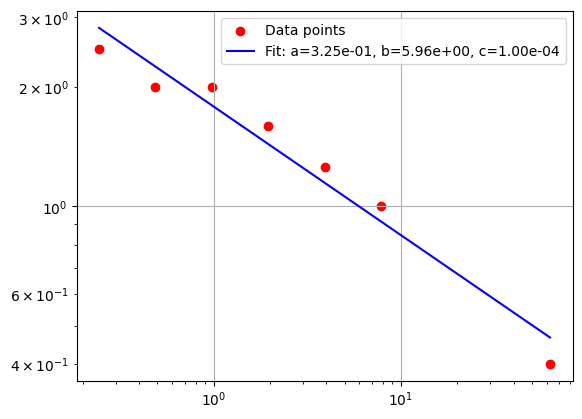

In [42]:
# debugging - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
# print(optim_f(lbfgs_pred, utd, learning_rate))

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


loss 0.5930335131938353
y = 4.80e+00 + (x/5.27e+00)^--3.22e+00


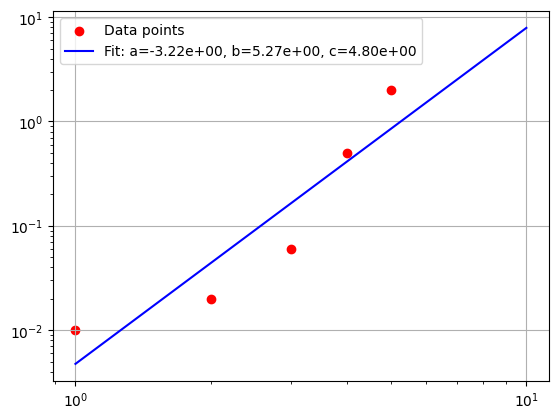

In [19]:
# debugging - fit(), toy data

x = np.array([1,2,3,4,5])
y = np.array([1,2,6,50,200])/100
fitted_params = fit(x, y, power_law_with_const_min, [slice(0.0, 4, 0.1),slice(1e-2, 10, 0.1),slice(0.0, 5, 0.1)])
print('loss', power_law_with_const_min(fitted_params, x, y))
a, b, c = fitted_params
x_smooth = np.logspace(0, 1, 100)
# y_fitted = power_law_with_const(x_smooth, a, b, c)
y_fitted = power_law_with_const(x_smooth, a, b, c)

print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.scatter(x, y, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={a:.2e}, b={b:.2e}, c={c:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40584D+00    |proj g|=  2.64022D+00
loss 7.40584054858825
y = 1.34e-04 + (x/2.75e+00)^--1.50e+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   2.640D+00   7.406D+00
  F =   7.4058405485882499     

ABNORMAL_TERMINATION_IN_LNSRCH                              


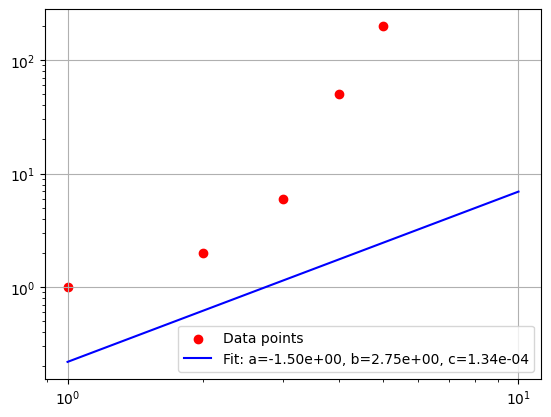

In [18]:
# debugging - minimize(), toy data


def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c):
    return min(c, 0) + (x/b)**(-a)

x = np.array([1,2,3,4,5])
y = np.array([1,2,6,50,200])/1
initial_params = [-1.5, 2.75, 1.34e-4]  # Initial guess for parameters
result = scipy.optimize.minimize(power_law_with_const_min, initial_params, args=(x, y), method='L-BFGS-B', options={'disp': True})
fitted_params = result.x
print('loss', power_law_with_const_min(fitted_params, x, y))
a, b, c = fitted_params
x_smooth = np.logspace(0, 1, 100)
y_fitted = power_law_with_const(x_smooth, a, b, c)

print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.scatter(x, y, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={a:.2e}, b={b:.2e}, c={c:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
 99%|█████████▉| 124/125 [00:03<00:00, 34.23it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
100%|██████████| 125/125 [00:03<00:00, 37.03it/s]


y = -1.49e+00 + (x/6.84e+03)^-1.36e-01


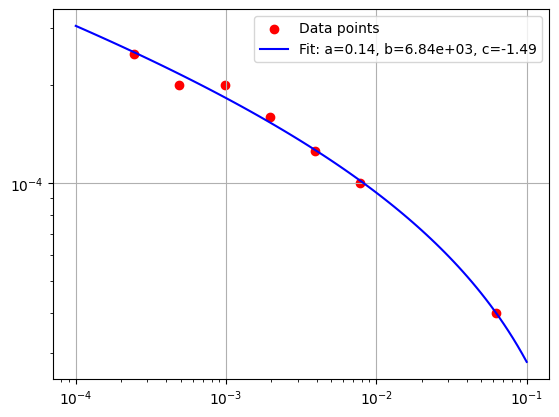

In [8]:
def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c + (x/b)**(-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
rescaling = [1000, 10000]

current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
fitted_params = fit(utd * rescaling[0], learning_rate * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in power


loss 0.14382074059918618
y = 2.00e-05 + (x/9.90e-17)^-3.00e-01


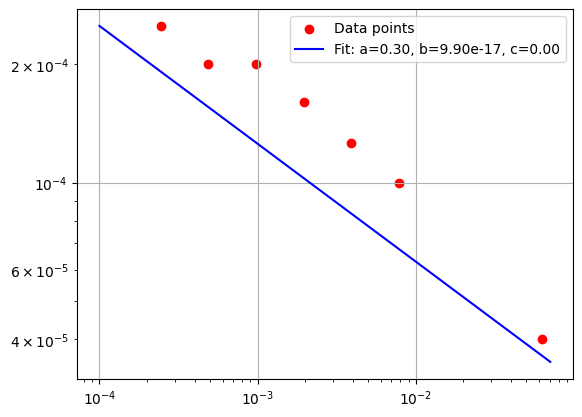

In [29]:

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

n_parallel = np.array([ 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel* 8
learning_rate = np.array([ 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

x = (utd,)
y = learning_rate
fitted_params = fit(x, y, power_law_with_const_min, [slice(0, 4, 0.1),slice(1e-18, 1e-16, 1e-18),slice(1e-5, 5e-4, 1e-5)])
print('loss', power_law_with_const_min(fitted_params, x, y))
a, b, c = fitted_params
x_smooth = np.logspace(-4, -1.15, 100)
y_fitted = power_law_with_const(x_smooth, a, b, c)


n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel* 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


loss nan
y = 1.00e+00 / (1 + x/-4.11e-03)^-2.50e-01


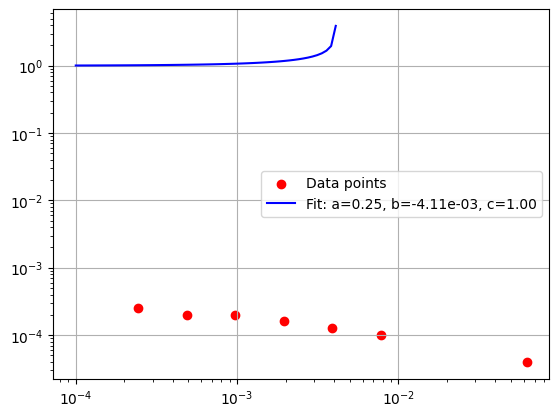

In [68]:
# large-batch training

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()

def lr_rule(x, a, b, c):
    # return c + (x/b)**(-a)
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

n_parallel = np.array([ 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel* 8
learning_rate = np.array([ 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

x = utd
y = learning_rate
fitted_params = fit(x, y, lr_rule_min, [slice(-4, 4, 0.25),slice(1e-18, 4, 0.25),slice(-4, 4, 0.25)], tol=1e-10)
print('loss', lr_rule_min(fitted_params, x, y))
a, b, c = fitted_params
x_smooth = np.logspace(-4, -1.15, 100)
y_fitted = lr_rule(x_smooth, a, b, c)


n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel* 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

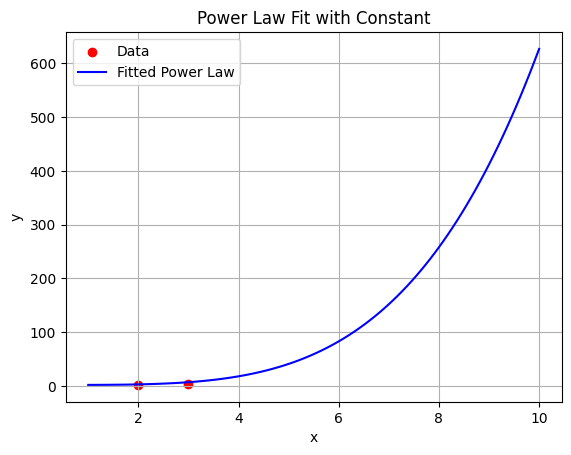

In [5]:
import numpy as np
from scipy import optimize
params = ((2,2), (3,3))

def power_law_with_const(x, a, b, c):
    return c + (x/b)**(-a)

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    return ((c + (x/b)**(-a) - y) ** 2).mean()

def f(args, *params):
    x, y = params
    a, b, c = args
    return (x * a**2 + y * b + c)

rranges = (slice(-4, 4, 0.25),slice(1e-18, 4, 0.25),slice(-4, 4, 0.25))
resbrute = optimize.brute(power_law_with_const_min, rranges, args=params, full_output=True, finish=optimize.fmin)
resbrute[0], resbrute[1]

import matplotlib.pyplot as plt

# Generate x values for smooth curve
x_plot = np.linspace(1, 10, 100)

# Get optimal parameters from brute force optimization
a_opt, b_opt, c_opt = resbrute[0]

# Calculate fitted y values
y_plot = power_law_with_const(x_plot, a_opt, b_opt, c_opt)

# Plot original data points
plt.scatter(*zip(*params), color='red', label='Data')

# Plot fitted curve
plt.plot(x_plot, y_plot, 'b-', label='Fitted Power Law')

plt.xlabel('x')
plt.ylabel('y') 
plt.title('Power Law Fit with Constant')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# loglog linear fit

logx = np.log(x)
logy = np.log(y)
# Fit a line
print(logx.shape, logy.shape)
a, b = np.polyfit(logx[0], logy, 1)
c = 0

x_smooth = np.logspace(-4, -1.15, 100)
y_fitted = np.exp(a*np.log(x_smooth) + b)
# y_fitted = power_law_with_const(x_smooth, a, b, c)
print(a, b, c, x_smooth, y_fitted)

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

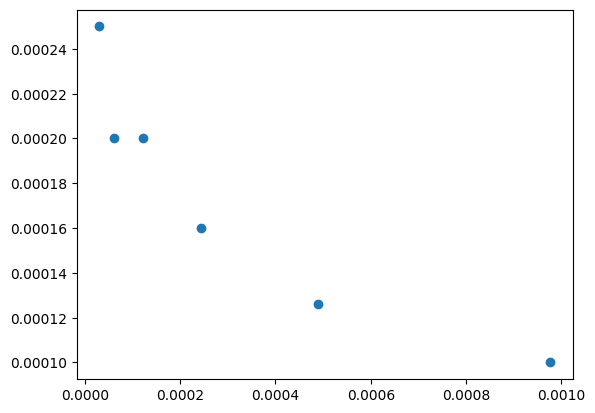

In [56]:
# Curve fit

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
n_parallel = np.array([ 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel
learning_rate = np.array([ 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
plt.scatter(utd, learning_rate)


def power_law_with_const(x, a, b, c):
    return c + (x/b)**(-a)
scaling = [1000, 10000]
popt, pcov = curve_fit(power_law_with_const, utd * scaling[0], learning_rate * scaling[1], p0=[0.25, 1e-5, 1e-5], maxfev=100000)

utd = np.linspace(1e-1, 1e-5)
plt.plot(utd, power_law_with_const(utd, *popt), linestyle='--')
print(f"y = {popt[2]:.2e} + (x/{popt[1]:.2e})^-{popt[0]:.2e}")

plt.xscale('log')
plt.yscale('log')
plt.ylabel('learning rate')
plt.xlabel('utd')